# Understand shape of variables (Univariate)

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Check working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Ask pandas to display all columns
pd.set_option('display.max_columns', None)

Current Directory: /Users/yun/Documents/GLIMS/glims_notebooks


In [2]:
# Load Esri shapefiles as geopandas dataframes
points = gpd.read_file("GLIMS_20230716/glims_download_13173/glims_points.shp")
polygons = gpd.read_file("GLIMS_20230716/glims_download_13173/glims_polygons.shp")
#polygons2 = gpd.read_file("GLIMS_20230716/polygons2.csv")

# Load the world countries data from the Natural Earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
# Change to datetime
polygons[['anlys_time', 'src_date']] = polygons[['anlys_time', 'src_date']].apply(pd.to_datetime)

# Remove submission-related columns
polygons1 = polygons.drop(labels=[
    'rec_status', 'wgms_id', 'local_id', 
    'subm_id', 'release_dt', 'proc_desc', 
    'rc_id', 'geog_area', 'chief_affl', 
    'loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y',
    'submitters', 'analysts'
], axis=1)

# Remove non-glacier entities.
polygons2 = polygons1[polygons1.line_type=="glac_bound"]
#polygons2.line_type.value_counts()
polygons2.drop('line_type', axis=1, inplace=True)

/var/folders/13/hf_sfnls1lq6kn8vsc92q40h0000gn/T/ipykernel_47969/2515722808.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons2.drop('line_type', axis=1, inplace=True)


## Categorical - IDs

### Count Glaciers
Verify how many glaciers there are, evaluating the integrity of ID categories. 

The points data provides an expected count.

| Basic Statistic | Points Data | 
| --------------- | --------------- | 
| Number of glaciers    | 328116 (glacial_id) |

In [4]:
# Verify that each point feature represents a unique glacier

# Number of points entries
print(points.shape[0])

# Unique points IDs
points.glacier_id.nunique()

328116


328116

In the glacial-subsetted polygons data, 
- Relatively few glaciers have names; this category may be trivial for now.
- polygons glac_id < points glacial_id. Perhaps some points were lost when subsetting glacial entities.
- glac_id << (geometries < anlyt_id < row entries). Perhaps many glaciers are analyzed more than once. Perhaps new analyses often but not always produce new geometries, reflecting changes in glacier size. Perhaps some glaciers are represented by more than one polygon.


| Basic Statistic | Points Data | Glacial Polygons Data | 
| --------------- | --------------- | --------------- |
| Number of glaciers    | 328116 (glacial_id) | 328112 (glac_id)  |
| Number of glacier analyses (snapshots)    | -  |      565887 (anlys_id)  |

In [5]:
# Row entries
print(polygons2.shape[0])

# Unique ids
polygons2[['anlys_id', 'glac_id', 'glac_name', 'geometry']].nunique()

564112


anlys_id     557878
glac_id      328112
glac_name     35111
geometry     528652
dtype: int64

However, in the non-subsetted polygons data including non-glacial entities, the number of unique glac_id is even closer to the expected glacier count. 

| Basic Statistic | Points Data | Polygons Data | Glacial Polygons Data | 
| --------------- | --------------- | --------------- | --------------- |
| Number of glaciers    | 328116 (glacial_id) |  328115 (glac_id)  |  328112 (glac_id)  |
| Number of glacier analyses (snapshots)    | - | -   |      565887 (anlys_id)  |

In [6]:
# Row entries
print(polygons.shape[0])

polygons[['anlys_id', 'glac_id', 'glac_name', 'geometry']].nunique()

565887


anlys_id     557884
glac_id      328115
glac_name     35112
geometry     530099
dtype: int64

### Resolve Discrepancies
Further inspection identifies the discrepancies of glaciers without polygons, missing data.

,glacier_id,geometry
14810,G013275E47098N,POINT Z (13.27500 47.09800 0.00000)
150588,G087657E50098N,POINT Z (87.65700 50.09800 0.00000)
258013,G286571E47471S,POINT Z (-73.42900 -47.47100 0.00000)
259079,G286669E47411S,POINT Z (-73.33100 -47.41100 0.00000)


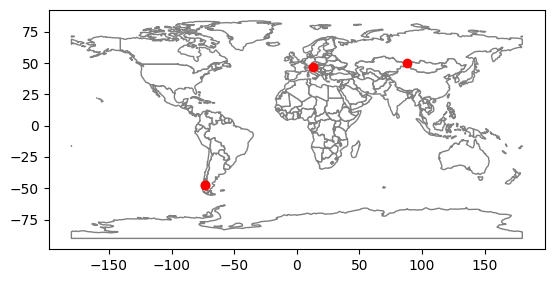

In [9]:
# points data entries not in polygons2 data
unaccounted2 = points[~points['glacier_id'].isin(polygons2['glac_id'])]

# map points data entries not in polygons2 data
ax2 = world.plot(color='white', edgecolor='grey');
unaccounted2.plot(ax=ax2, color = 'red');

unaccounted2

Here is the only glacier with a representative point but no polygon features.

,glacier_id,geometry
150588,G087657E50098N,POINT Z (87.65700 50.09800 0.00000)


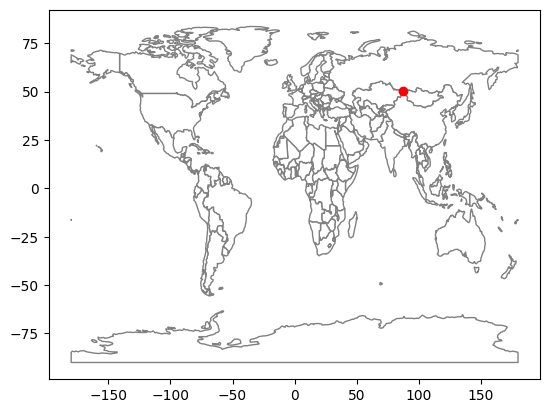

In [10]:
# points data entries not in polygons data
unaccounted = points[~points['glacier_id'].isin(polygons['glac_id'])]

# map points data entries not in polygons data
ax = world.plot(color='white', edgecolor='grey');
unaccounted.plot(ax=ax, color = 'red');

unaccounted

And here are the glaciers without glacial polygons, only nunatek polygons.

In [11]:
# glac_id that were lost in the subsetting
unnacounted21 = polygons[polygons.glac_id.isin(unaccounted2.glacier_id)]
unnacounted21

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,rec_status,glac_name,wgms_id,local_id,glac_stat,subm_id,release_dt,proc_desc,rc_id,geog_area,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,geometry
279735,intrnl_rock,346955.0,G013275E47098N,2012-06-30 00:00:00,0.00,0.098722,0.0,0.0,0.0,0.0,0.0,0.0,2012-06-30,okay,"Gstss Kees E,",None,None,exists,603.0,2016-03-07T09:00:00,"Where no lidar data were available,the GI 2 gl...",34.0,Austrian Alps,Universitaet Innsbruck,50,50,30,30,"Fischer, Andrea","Fischer, Andrea","POLYGON Z ((13.28654 47.09805 0.00000, 13.2865..."
351409,intrnl_rock,2152.0,G286571E47471S,2005-07-14 23:33:02,1.29,1.273130,0.0,0.0,0.0,0.0,0.0,0.0,2001-03-11,okay,None,50,NPI-50,None,100.0,2005-12-20T19:43:58,Manually digitised; A manually-based procedure...,20.0,"Chilean glaciers, between -18 and -56 degrees ...",Universidad de Chile,0,0,0,0,"Bown, Francisca","Rivera, Andres","POLYGON Z ((-73.42454 -47.46965 0.00000, -73.4..."
353371,intrnl_rock,2154.0,G286669E47411S,2005-07-14 23:33:02,1.00,0.999455,0.0,0.0,0.0,0.0,0.0,0.0,2001-03-11,okay,None,55,NPI-55,None,100.0,2005-12-20T19:43:58,Manually digitised; A manually-based procedure...,20.0,"Chilean glaciers, between -18 and -56 degrees ...",Universidad de Chile,0,0,0,0,"Bown, Francisca","Rivera, Andres","POLYGON Z ((-73.33914 -47.41311 0.00000, -73.3..."
353372,intrnl_rock,2154.0,G286669E47411S,2005-07-14 23:33:02,1.00,0.999455,0.0,0.0,0.0,0.0,0.0,0.0,2001-03-11,okay,None,55,NPI-55,None,100.0,2005-12-20T19:43:58,Manually digitised; A manually-based procedure...,20.0,"Chilean glaciers, between -18 and -56 degrees ...",Universidad de Chile,0,0,0,0,"Bown, Francisca","Rivera, Andres","POLYGON Z ((-73.33764 -47.41012 0.00000, -73.3..."


Considering these glaciers to have existed at least at some point, the points data provides the most complete count of glaciers.

### Compare Summary Statistics

These counts can be compared with the GLIMS [Summary Statistics](http://glims.colorado.edu/glacierdata/db_summary_stats.php) page (unknown date of last update, accessed Aug 3, 2023).

| Basic Statistic | EDA Counts | Summary Statistics Report | 
| --------------- | --------------- | --------------- |
| Number of glaciers    | 328116 (points glacial_id)    | 444740 (200,000)    | 
| Number of glacier analyses (snapshots)    | 565887 (polygons anlys_id)   | 699217    | 

The page notes that some glaciers were double-counted by having multiple glacier ID, that this problem would eventually be fixed, and that 200,000 was a reasonable estimate for the number of glaciers on earth. This may explain why the counts of this EDA are lower, if its data is more recent.

### Count Analyses
The page also states that 173148 glaciers have multi-temporal coverage. This means many glaciers were analyzed more than once, an explanation for glac_id << (geometries < anlyt_id < row entries). To demonstrate:

In [ ]:
# EDA
print(565887 - 173148, "\u2248", 328116)

# GLIMS Summary Statistics Report
print(699217 - 173148, "\u2248", 565887)

In [12]:
# See some recurring glacier ids
polygons2.glac_id.value_counts()

G302228E64270S    75
G299054E63854S    33
G068799E49603S    29
G008010E46588N    22
G011972E47060N    21
                  ..
G285246E81397N     1
G286657E80112N     1
G280384E81976N     1
G288449E80529N     1
G278941E82406N     1
Name: glac_id, Length: 328112, dtype: int64

In [13]:
# Investigate one of the recurring glacier ids.
# Each of its rows are unique - in which fields do they differ?
G011972E47060N = polygons2[polygons2.glac_id=="G011972E47060N"]
G011972E47060N.duplicated()

264610    False
277696    False
278454    False
278455    False
278456    False
278457    False
278458    False
278459    False
278460    False
280076    False
280077    False
280078    False
280079    False
280080    False
280081    False
280082    False
329749    False
380530    False
556594    False
556595    False
556596    False
dtype: bool

In [35]:
# In which fields do they differ?
# Some have different anlys_id and anlys_time entries
print(G011972E47060N.shape)
G011972E47060N.head()

(21, 15)


,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,geometry
264610,335334.0,G011972E47060N,2010-06-01,0.013,0.012598,0.0,0.0,0.0,3033.0,3081.0,3123.0,2003-08-24,"NN,",exists,"POLYGON Z ((11.97214 47.05956 0.00000, 11.9717..."
277696,344815.0,G011972E47060N,2007-01-01,0.000,0.448882,0.0,0.0,0.0,0.0,0.0,0.0,1969-06-30,"NN,",exists,"POLYGON Z ((11.97374 47.05906 0.00000, 11.9736..."
278454,345686.0,G011972E47060N,2007-06-30,0.000,0.234913,0.0,0.0,0.0,0.0,0.0,0.0,1998-06-30,"NN,",exists,"POLYGON Z ((11.97078 47.06422 0.00000, 11.9705..."
278455,345686.0,G011972E47060N,2007-06-30,0.000,0.234913,0.0,0.0,0.0,0.0,0.0,0.0,1998-06-30,"NN,",exists,"POLYGON Z ((11.97299 47.05911 0.00000, 11.9730..."
278456,345686.0,G011972E47060N,2007-06-30,0.000,0.234913,0.0,0.0,0.0,0.0,0.0,0.0,1998-06-30,"NN,",exists,"POLYGON Z ((11.97062 47.06688 0.00000, 11.9706..."


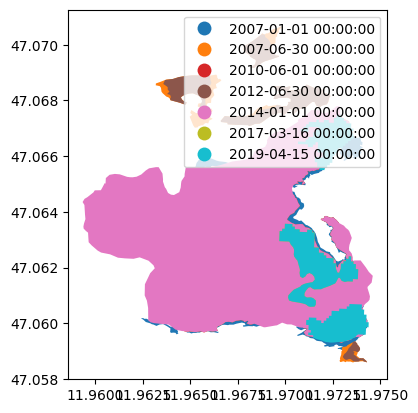

In [43]:
# Map examples of glacier size changes/stability across analyses
# This would be great for a time series
G011972E47060N.plot('anlys_time', categorical=True, legend=True);

In [15]:
# The rest have differing geometry
G011972E47060N.iloc[2] == G011972E47060N.iloc[3]

anlys_id       True
glac_id        True
anlys_time     True
area           True
db_area        True
width          True
length         True
primeclass     True
min_elev       True
mean_elev      True
max_elev       True
src_date       True
glac_name      True
glac_stat      True
geometry      False
dtype: bool

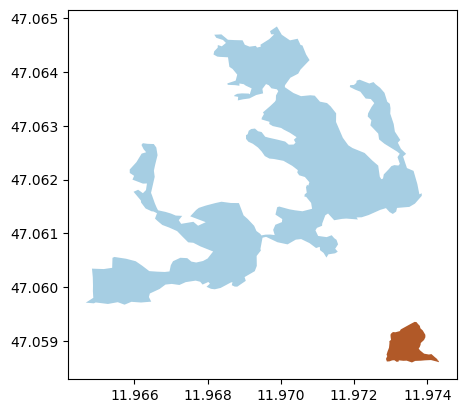

In [16]:
# Apparently these disconnected polygons belong to the same glacier ID
G011972E47060Nab=G011972E47060N.iloc[2:4]

# Map example of glacier having >1 glacial polygons. 
G011972E47060Nab.plot(cmap='Paired');

## Categorical - Non-ID

exists    558897
None        4906
gone         309
Name: glac_stat, dtype: int64

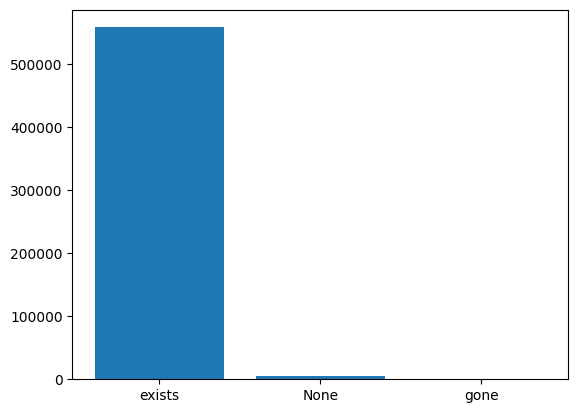

In [79]:
# A few hundred glaciers are gone; None means data NA
plt.bar(polygons2.glac_stat.value_counts().index, polygons2.glac_stat.value_counts().values);
polygons2.glac_stat.value_counts()

In [80]:
# Perhaps number of gone glaciers consistent with number of zero area glaciers (db_area)
# Are the "zero area" glaciers also "gone"?
dimensions.eq(0).sum()

NameError: name 'dimensions' is not defined

In [55]:
# convert primeclass variable to integer datatype instead of float
polygons2['primeclass'] = polygons2['primeclass'].astype(int)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
# 95% of polygons are in the other category. Could be an issue of missing data.
polygons2.primeclass.value_counts(normalize=True)

0     0.952410
9     0.014449
7     0.013435
6     0.012127
5     0.003301
4     0.002597
3     0.001057
10    0.000363
2     0.000259
8     0.000002
Name: primeclass, dtype: float64

0     537266
9       8151
7       7579
6       6841
5       1862
4       1465
3        596
10       205
2        146
8          1
Name: primeclass, dtype: int64

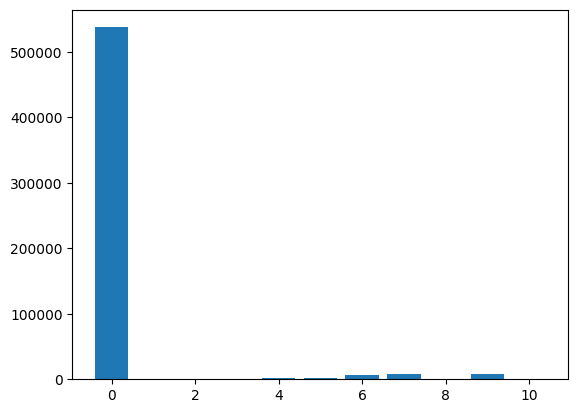

In [83]:
# Graphing
plt.bar(polygons2.primeclass.value_counts().index, polygons2.primeclass.value_counts().values);
polygons2.primeclass.value_counts()

In [75]:
# Investigate the other 5% -- they come from many providers, especially IANIGLA in Argentina
polygons[polygons.primeclass!=0].chief_affl.value_counts(normalize = True)

IANIGLA                                                              0.710136
International Centre for Integrated Mountain Development (ICIMOD)    0.120268
Durham University                                                    0.048995
University of Alberta                                                0.038005
University of Colorado                                               0.021537
Texas A and M University                                             0.015172
Royal Holloway University                                            0.010880
Russian Academy of Sciences                                          0.008955
Centro de Estudios Avanzados en Zonas Aridas (CEAZA)                 0.005773
OMP-LEGOS                                                            0.005588
Geographical Institute                                               0.003886
Universidade Federal do Rio Grande - FURG                            0.003627
RWTH Aachen University                                          

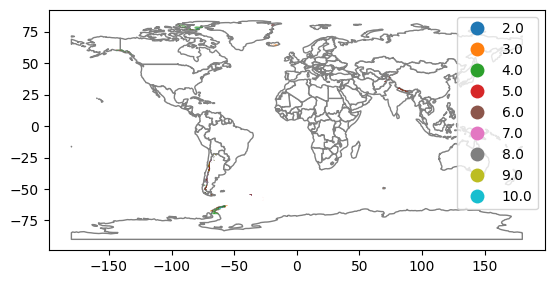

In [76]:
ax = world.plot(color='white', edgecolor='grey');
polygons[polygons.primeclass!=0].plot('primeclass', categorical=True, legend=True, ax=ax);

In [ ]:
# https://wgms.ch/data_submission/
# https://wgms.ch/downloads/FoG_Submission_instructions.pdf